### Examine the accuracy in the amplitude of mock light curves simulated by `Kali`

<br>**Author(s):** Weixiang Yu
<br>**Last run:** 07-10-20
<br>**Short description:** This notebook will try to validate the `Kali` simulated mock CARMA light curves from the perspective of the amplitude. In short, standard deviation of a simulated light curve should match the input value the amplitude of a CARMA process.

## 0. Setup

In [1]:
# import basic packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import os, sys

# see if local stores mpl style, else use from src
try:
    plt.style.use('yu_basic')
except:
    mpl.rc_file('https://raw.githubusercontent.com/ywx649999311/project_template'
                '/master/%7B%7Bcookiecutter.project_name%7D%7D/src/vis/mpl/yu_basic.rc')
    
pd.set_option('display.max_columns', 999)
%matplotlib inline

import dask

In [2]:
# import kali modules
import kali.carma

## 1. Test Mock LC
### 1.1 Mock DRW LC
In this section, we will simulate a collection of DRW light curves using a grid placed in the parameter space of $\tau$ and the standard deviate ($\sigma_{DRW}^{2} = \frac{\tau\sigma^{2}}{2}$) of the simulated light curves. We will uniformly draw parameters from 10 days < $\tau$ < 365 days and 0.05 mag < $\sigma_{DRW}$ < 0.35 mag. The simulated light curves will have a 1 day cadence and 10/50 years baseline.

#### 1.1.1 Compute percentage err (LC length = 10 years)

In [3]:
# funtion to parallel LC simulation with Dask
@dask.delayed
def simLC(lcArr, theta, row, col, dt=1.0, duration=3650.0):

    try:
        lc_length = int(duration/dt)
        task = kali.carma.CARMATask(1,0)
        task.set(dt, theta)
        lc = task.simulate(duration=duration)
        lcArr[row, col, :] = lc.x
    except:
        print(f'Failed at ({row}, {col})!')
        return 1
    
    return 0

In [7]:
# construct grid in param space
dim = 50
sigma_drw = np.linspace(0.05, 0.35, dim)
tau = np.linspace(10, 365, dim)
# print(f'Input amp: \n {sigma_drw} \n')
# print(f'Input timscale: \n{tau}')

# construct arr to store lc
lc_arr1 = np.empty((dim,dim,3650))

In [8]:
#simLC
all_result1 = []
for tau_i in range(dim):
    for var_i in range(dim):
        theta = kali.carma.coeffs(1,0, np.array([-1/tau[tau_i], sigma_drw[var_i]]))
        all_result1.append(simLC(lc_arr1, theta, tau_i, var_i, duration=3650.0))
total1 = dask.delayed(sum)(all_result1)
sum_num1 = total1.compute()
print(sum_num1)

0


In [9]:
# compute amp from simulated lc
std_arr1 = np.empty((dim,dim))
for tau_i in range(dim):
    for var_i in range(dim):
        std_arr1[tau_i, var_i] = np.std(lc_arr1[tau_i, var_i, :])

In [10]:
# compare percentage error to input
input_2d_amp = np.repeat(np.expand_dims(sigma_drw, axis=0), dim, axis=0)
diff_amp1 = np.abs(std_arr1 - input_2d_amp)
percent_err1 = 100*diff_amp1/input_2d_amp

#### 1.1.2 Compute percentage err (LC length = 50 years)

In [11]:
# construct arr to store lc
lc_arr2 = np.empty((dim,dim,10*3650))

In [13]:
all_result2 = []
for tau_i in range(dim):
    for var_i in range(dim):
        theta = kali.carma.coeffs(1,0, np.array([-1/tau[tau_i], sigma_drw[var_i]]))
        all_result2.append(simLC(lc_arr2, theta, tau_i, var_i, duration=10*3650.0))
total2 = dask.delayed(sum)(all_result2)
sum_num2 = total2.compute()
print(sum_num2)

0


In [106]:
# compute amp from simulated lc
std_arr2 = np.empty((dim,dim))
for tau_i in range(dim):
    for var_i in range(dim):
        std_arr2[tau_i, var_i] = np.std(lc_arr2[tau_i, var_i, ::10])

In [107]:
# compare percentage error to input
input_2d_amp = np.repeat(np.expand_dims(sigma_drw, axis=0), dim, axis=0)
diff_amp2 = np.abs(std_arr2 - input_2d_amp)
percent_err2 = 100*diff_amp2/input_2d_amp

#### 1.1.3 Plot perfentage error as function of timescales (compare 10 years vs. 100 years)

Text(0.5, 1.0, 'Percentage error for 100 years light curves')

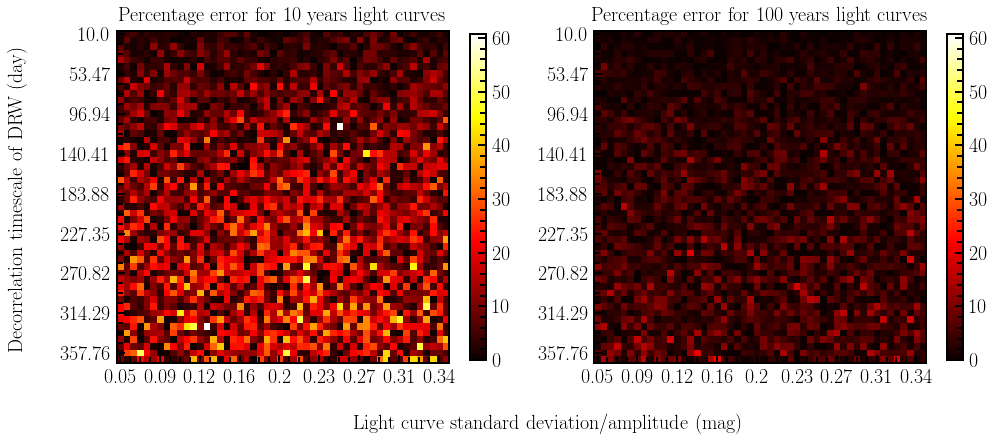

In [108]:
import matplotlib.colors as colors

# plot for 10 year baseline light curves
fig, axs = plt.subplots(1, 2, figsize=(16,8))

im0 = axs[0].imshow(percent_err1, cmap='hot')
im1 = axs[1].imshow(percent_err2, cmap='hot')
im0.set_norm(colors.Normalize(vmin=0, vmax=im0.get_array().max()))
im1.set_norm(colors.Normalize(vmin=0, vmax=im0.get_array().max()))
fig.colorbar(im0, ax=axs[0], shrink=0.75)
fig.colorbar(im1, ax=axs[1], shrink=0.75)

tick_scale = int(dim/8)
_ = axs[0].set_xticks(np.arange(dim)[::tick_scale])
_ = axs[0].set_xticklabels(np.around(sigma_drw, 2)[::tick_scale])
_ = axs[1].set_xticks(np.arange(dim)[::tick_scale])
_ = axs[1].set_xticklabels(np.around(sigma_drw, 2)[::tick_scale])

_ = axs[0].set_yticks(np.arange(dim)[::tick_scale])
_ = axs[0].set_yticklabels(np.around(tau, 2)[::tick_scale])
_ = axs[1].set_yticks(np.arange(dim)[::tick_scale])
_ = axs[1].set_yticklabels(np.around(tau, 2)[::tick_scale])

fig.text(0.5, 0.1, 'Light curve standard deviation/amplitude (mag)', ha='center', fontsize=20)
fig.text(0.03, 0.5, 'Decorrelation timescale of DRW (day)', va='center', rotation='vertical')
axs[0].set_title('Percentage error for 10 years light curves', pad=10)
axs[1].set_title('Percentage error for 100 years light curves', pad=10)
# plt.savefig('Kali_amp_validate.pdf')